In [1]:
### 사용할 라이브러리
# 데이터처리
import pandas as pd
import numpy as np

# 데이터분류
from sklearn.model_selection import train_test_split

# 하이퍼파라메터 튜닝
from sklearn.model_selection import GridSearchCV

# 분류모델
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier

# 평가
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# 오차행렬 매트릭스 및 오차행렬도
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
"""
* 주제 : 와인분류하기
- 사용 데이터 : 08_wine.csv

* 분석방법
- 스케일링 : 스탠다스 스케일러 사용
- 데이터 분류 : 훈련/검증/테스트 = 6:2:2로 분류하여 사용
- 하이퍼파라메터 튜닝 진행

<튜닝 속성>
- HGB : max_iter = [50, 100]
      : max_depth = [None, 10]
      : min_samples_leaf = [1, 2, 4]

- XGB : n_estimatore = [50, 100]
      : max_depth = [None, 10]
      : min_child_weight = [1, 2, 4]

- 나머지 모델 : n_estimatore = [50, 100]
             : max_depth = [None, 10]
             : min_samples_split = [2, 5]
             : min_samples_leaf = [1, 2, 4]

- scoring = accuracy 사용
- cv = 5 사용
- refit은 사용안해도 됨
             
<최종결과>
- 데이터프레임에 담아서 출력
    * 컬럼명 : 모델명, 훈련정확도, 검증정확도, (훈련-검증), 정밀도, 재현율, F1-score
    
- 최종모델 선정 후
    * 테스트 정확도, 정밀도, 재현율, F1-score 확인

- 하이퍼파라메터 튜닝 전과 튜닝 후로 구분하여 모델 선정
"""

'\n* 주제 : 와인분류하기\n- 사용 데이터 : 08_wine.csv\n\n* 분석방법\n- 스케일링 : 스탠다스 스케일러 사용\n- 데이터 분류 : 훈련/검증/테스트 = 6:2:2로 분류하여 사용\n- 하이퍼파라메터 튜닝 진행\n\n<튜닝 속성>\n- HGB : max_iter = [50, 100]\n      : max_depth = [None, 10]\n      : min_samples_leaf = [1, 2, 4]\n\n- XGB : n_estimatore = [50, 100]\n      : max_depth = [None, 10]\n      : min_child_weight = [1, 2, 4]\n\n- 나머지 모델 : n_estimatore = [50, 100]\n             : max_depth = [None, 10]\n             : min_samples_split = [2, 5]\n             : min_samples_leaf = [1, 2, 4]\n\n- scoring = accuracy 사용\n- cv = 5 사용\n- refit은 사용안해도 됨\n             \n<최종결과>\n- 데이터프레임에 담아서 출력\n    * 컬럼명 : 모델명, 훈련정확도, 검증정확도, (훈련-검증), 정밀도, 재현율, F1-score\n    \n- 최종모델 선정 후\n    * 테스트 정확도, 정밀도, 재현율, F1-score 확인\n\n- 하이퍼파라메터 튜닝 전과 튜닝 후로 구분하여 모델 선정\n'

In [3]:
### 08_wine.csv 데이터 읽어들이기
# 변수명 : wine
file_path = "./data/08_wine.csv"
wine = pd.read_csv(file_path)
wine

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0
...,...,...,...,...
6492,11.2,1.6,3.27,1.0
6493,9.6,8.0,3.15,1.0
6494,9.4,1.2,2.99,1.0
6495,12.8,1.1,3.34,1.0


In [4]:
### 결측치와 이상치 기본 확인하기
wine.info()
wine.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [5]:
### 전체 특성에 대한 행단위 중복체크
wine[wine.duplicated() == True]

,alcohol,sugar,pH,class
4,9.400000,1.90,3.51,0.0
11,10.500000,6.10,3.35,0.0
27,9.500000,1.60,3.17,0.0
40,10.500000,5.90,3.33,0.0
65,10.900000,4.65,3.41,0.0
...,...,...,...,...
6455,9.000000,13.70,2.90,1.0
6457,9.600000,7.80,3.12,1.0
6459,11.000000,7.70,3.04,1.0
6479,9.533333,8.10,3.15,1.0


In [6]:
### 독립변수와 종속변수로 데이터 분리하기
# 독립변수명 : data
# 종속변수명 : target
# numpy 배열 타입으로 데이터를 분리 생성해주세요.

In [7]:
data = wine.iloc[:, :-1].to_numpy()
data.shape

(6497, 3)

In [8]:
target = wine['class'].to_numpy()
target.shape

(6497,)

In [9]:
### 데이터 나누기
# 6(훈련데이터) : 4(검증+테스트 데이터) 분류
data_train, data_temp, target_train, target_temp = train_test_split(data, target, test_size=0.4, random_state=42)

# 4(검증+테스트 데이터)를  5(검증) : 5(테스트)로 분류
data_val, data_test, target_val, target_test = train_test_split(data_temp, target_temp, test_size=0.5, random_state=42)

# 결과 확인
print("Training set data:\n", data_train, data_train.shape)
print("Val set data:\n", data_val, data_val.shape)
print("Test set data:\n", data_test, data_test.shape)
print("Training set target:\n", target_train, target_train.shape)
print("Val set target:\n", target_val, target_val.shape)
print("Test set target:\n", target_test, target_test.shape)

Training set data:
 [[12.7   2.2   3.31]
 [10.    7.5   3.22]
 [12.1   1.2   3.13]
 ...
 [ 9.5   5.6   3.24]
 [ 9.5   8.    3.18]
 [ 9.5   2.7   3.51]] (3898, 3)
Val set data:
 [[11.    2.7   3.33]
 [ 9.1  12.8   3.14]
 [12.5   8.3   2.96]
 ...
 [ 9.    1.4   3.11]
 [10.5   1.9   3.34]
 [11.2   1.4   3.21]] (1299, 3)
Test set data:
 [[ 9.4   8.2   3.2 ]
 [10.2   2.2   3.18]
 [10.1   1.7   3.37]
 ...
 [ 9.1   2.2   3.36]
 [ 9.5   1.7   3.46]
 [10.8  11.7   3.14]] (1300, 3)
Training set target:
 [1. 1. 1. ... 1. 1. 0.] (3898,)
Val set target:
 [0. 1. 1. ... 1. 0. 1.] (1299,)
Test set target:
 [1. 0. 1. ... 0. 0. 1.] (1300,)


In [10]:
### StandardScaler로 정규화하기
# 클래스명 : ss
# 독립변수명 : train_std_scaler, test_std_scaler
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(data_train)

StandardScaler()

In [11]:
data_train_scaled = ss.transform(data_train)
data_val_scaled = ss.transform(data_val)
data_test_scaled = ss.transform(data_test)

data_train_scaled.shape, data_val_scaled.shape, data_test_scaled.shape

((3898, 3), (1299, 3), (1300, 3))

In [12]:
### 샘플 테스트
rf_reg = RandomForestClassifier()
rf_reg

RandomForestClassifier()

In [13]:
### 하이퍼파라메터 값의 범위 지정하기
gridParams = {}
# 랜덤포레스트에서 훈련에 사용할 트리의 갯수 범위 지정
gridParams["n_estimators"] = [50, 100]
# 랜덤포레스트에서 훈련 시 트리가 밑으로 뻗어나가는 최대 깊이(None는 제한을 두지 않겟다는 의미)
gridParams["max_depth"] = [None, 10]

gridParams

{'n_estimators': [50, 100], 'max_depth': [None, 10]}

In [14]:
### 튜닝객체 생성하기
grid_search_model = GridSearchCV(rf_reg, gridParams, scoring='accuracy', cv=5, n_jobs=-1)
grid_search_model

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10], 'n_estimators': [50, 100]},
             scoring='accuracy')

In [15]:
### 튜닝객체 훈련시키기(모델 훈련시키기)
grid_search_model.fit(data_train_scaled, target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10], 'n_estimators': [50, 100]},
             scoring='accuracy')

In [16]:
best_model = grid_search_model.best_estimator_
best_model

RandomForestClassifier()

In [17]:
### 하이퍼파라메터 튜닝을 위한 함수 생성하기
# 함수 이름 : get_HyperParameter_Tuning

def get_HyperParameter_Tuning(model, gridParams, scoring, data_train, train_target, data_val, val_target, cv=5, n_jops=-1):

    ### 튜닝객체 생성하기
    grid_search_model = GridSearchCV(model, gridParams, scoring='accuracy', cv=5, n_jobs=-1)

    ### 튜닝객체 훈련시키기(모델 훈련시키기)
    grid_search_model.fit(data_train, target_train)

    ### 최적의 모델을 변수로 받아오기
    best_model = grid_search_model.best_estimator_

    ### 데스트 데이터 평가
    # 훈련 예측하기
    train_pred = best_model.predict(data_train)
    
    ### 정확도(accuracy_score)
    train_acc = accuracy_score(train_target, train_pred)
    
    ### 정밀도(precision_score)
    train_pre = precision_score(train_target, train_pred)
    
    ### 재현율(recall_score)
    train_rec = recall_score(train_target, train_pred)
    
    ### F1-Score
    train_f1 = f1_score(train_target, train_pred)

    ### 검증데이터 평가
    # 훈련 예측하기
    val_pred = best_model.predict(data_val)
    
    ### 정확도(accuracy_score)
    val_acc = accuracy_score(val_target, val_pred)
    
    ### 정밀도(precision_score)
    val_pre = precision_score(val_target, val_pred)
    
    ### 재현율(recall_score)
    val_rec = recall_score(val_target, val_pred)
    
    ### F1-Score
    val_f1 = f1_score(val_target, val_pred)

    return best_model, train_acc, train_pre, train_rec, train_f1, val_acc, val_pre, val_rec, val_f1

In [18]:
### 훈련에 사용할 모델 생성하기
rf_reg = RandomForestClassifier()
gb_reg = GradientBoostingClassifier()
et_reg = ExtraTreesClassifier()
hgb_reg = HistGradientBoostingClassifier()
xgb_reg = XGBClassifier()

### 리스트에 담아서 반복 수행 할 수 있도록 처리
models = [rf_reg, gb_reg, et_reg, hgb_reg, xgb_reg]
models

[RandomForestClassifier(),
 GradientBoostingClassifier(),
 ExtraTreesClassifier(),
 HistGradientBoostingClassifier(),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...)]

In [19]:
### 튜닝 함수 호출하기
# 각 모델 리턴 결과 저장할 딕셔너리 변수 정의
results = {}

# 각 모델의 실행결과를 데이터프레임에 담을 변수 정의
rs_df = pd.DataFrame()

for m in models :
    ### 모델 이름 추출
    modelName = m.__class__.__name__
    print(f"---------------------[{modelName}]----------------------")

    ### 하이퍼파라메터 속성이름과 값 범위 지정하기
    # 모델마다 속성이름이 다르기에 조건식으로 정의해야함

    ### 하이퍼파라메터를 담을 딕셔너리 변수 정의
    gridParams = {}
        
    ### HGB인 경우
    if modelName == "HistGradientBoostingClassifier" :
        # 트리 갯수 지정(보통 50~100 사이값 사용)
        gridParams["max_iter"] = [50, 100]
        # 트리가 뻗어나가는 최대 깊이 지정(None은 제안두지 않음, 보통 3~10 사이값 사용)
        gridParams["max_depth"] = [None, 10]
        # 각각의 결정 트리(Decision Tree)에서 최소한으로 필요한 샘플 수를 지정
        gridParams["min_samples_leaf"] = [1, 2, 4]

    ### XGB인 경우
    elif modelName == "XGBClassifier" :
        # 트리 갯수 지정(보통 50~100 사이값 사용)
        gridParams["n_estimators"] = [50, 100]
        # 트리가 뻗어나가는 최대 깊이 지정(None은 제안두지 않음, 보통 3~10 사이값 사용)
        gridParams["max_depth"] = [None, 10]
        # 각각의 트리에 대해 샘플의 최소 가중치 합계를 제한하는 역할
        gridParams["min_child_weight"] = [1, 2, 4]
    
    ### 나머지인 경우
    else:
        # 트리 갯수 지정(보통 50~100 사이값 사용)
        gridParams["n_estimators"] = [50, 100]
        # 트리가 뻗어나가는 최대 깊이 지정(None은 제안두지 않음, 보통 3~10 사이값 사용)
        gridParams["max_depth"] = [None, 10]
        gridParams["min_samples_split"] = [2, 5]
        # 각각의 결정 트리(Decision Tree)에서 최소한으로 필요한 샘플 수를 지정
        gridParams["min_samples_leaf"] = [1, 2, 4]
        

    ### 평가방법
    scoring = 'accuracy'

    ### 함수 호출하기 -----------------------------
    best_model, train_acc, train_pre, train_rec, train_f1, val_acc, val_pre, val_rec, val_f1 = get_HyperParameter_Tuning(m, gridParams, scoring, 
                                                                                                     data_train_scaled, target_train, data_val_scaled, target_val, cv=5, n_jops=-1)
    # print(best_model, train_mae, train_mse, train_r2, val_mae, val_mse, val_r2)

    ### 딕셔너리에 모델 별로 결과값 담기
    results[modelName] = [best_model, train_acc, train_pre, train_rec, train_f1, val_acc, val_pre, val_rec, val_f1]

    ### 데이터프레임에 모델 별로 결과값 담기
    rs_temp = pd.DataFrame([[modelName, train_acc, train_pre, train_rec, train_f1, val_acc, val_pre, val_rec, val_f1]],
                              columns=["model_name", "train_acc", "train_pre", "train_rec", "train_f1", "val_acc", "val_pre", "val_rec", "val_f1"])

    ### 원본 데이터프레임에 rs_temp 데이터를 행단위로 추가하기
    rs_df = pd.concat([rs_df, rs_temp], ignore_index=True)

---------------------[RandomForestClassifier]----------------------
---------------------[GradientBoostingClassifier]----------------------
---------------------[ExtraTreesClassifier]----------------------
---------------------[HistGradientBoostingClassifier]----------------------
---------------------[XGBClassifier]----------------------


In [20]:
rs_df

,model_name,train_acc,train_pre,train_rec,train_f1,val_acc,val_pre,val_rec,val_f1
0,RandomForestClassifier,0.997435,0.998320,0.998320,0.998320,0.877598,0.919421,0.916581,0.917999
1,GradientBoostingClassifier,0.994613,0.996974,0.995969,0.996471,0.879138,0.924843,0.912461,0.918611
2,ExtraTreesClassifier,0.978194,0.980080,0.991602,0.985807,0.884527,0.908458,0.940268,0.924089
3,HistGradientBoostingClassifier,0.950744,0.974770,0.960363,0.967513,0.876059,0.924528,0.908342,0.916364
4,XGBClassifier,0.974859,0.982245,0.984884,0.983563,0.874519,0.917355,0.914521,0.915936


In [21]:
"""
(해석)
 - 기존 하이퍼파라메터 튜닝 전에는 가장 일반화가 잘된 모델은 GB모델이었으나,
   튜닝 이후에는 HGB 모델이 가장 일반화 된것으로 분석되었음
 - 재현율의 경우에는 ET모델이 가장 높으나, HGB모델과 많은 차이을 보이고 있지 않기에
   가장 일반화가 잘 된 HGB모델로 선정하였음
"""

'\n(해석)\n - 기존 하이퍼파라메터 튜닝 전에는 가장 일반화가 잘된 모델은 GB모델이었으나,\n   튜닝 이후에는 HGB 모델이 가장 일반화 된것으로 분석되었음\n - 재현율의 경우에는 ET모델이 가장 높으나, HGB모델과 많은 차이을 보이고 있지 않기에\n   가장 일반화가 잘 된 HGB모델로 선정하였음\n'

In [22]:
### 오차행렬 및 오차행렬도 그리기를 함수로 정의
def conf_matrix_display(X_target, y_pred, model) :
    cm = confusion_matrix(X_target, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

In [23]:
### 최종 선정모델로 테스트하기...............................

train_acc=0.950744, test_acc=0.7308, train-test=0.2200, test_pre=0.7308, test_rec=1.0000, test_f1=0.8444


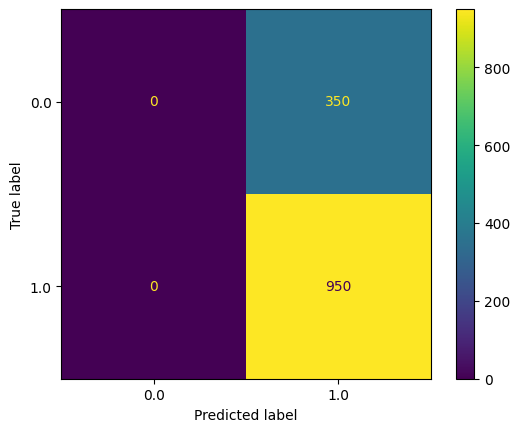

In [29]:
### 테스트 데이터로 예측 및 평가결과 확인하기
# 최종 선정모델 추출하기
f_model = results["HistGradientBoostingClassifier"][0]

test_pred = f_model.predict(data_test)
### 정확도(accuracy_score)
test_acc = accuracy_score(target_test, test_pred)
### 정밀도(precision_score)
test_pre = precision_score(target_test, test_pred)
### 재현율(recall_score)
test_rec = recall_score(target_test, test_pred)
### F1-score
test_f1 = f1_score(target_test, test_pred)

### 오차행렬도
conf_matrix_display(target_test, test_pred, f_model)

print(f"train_acc={0.950744}, test_acc={test_acc:.4f}, train-test={0.950744-test_acc:.4f}, \
test_pre={test_pre:.4f}, test_rec={test_rec:.4f}, test_f1={test_f1:.4f}")